In [1]:
from CaAttributes import CaNeighbourhoods, MemoryTypes, RuleTypes
import itertools
%load_ext autoreload
%autoreload 2
from CaMemory1D import CaMemory1D,Wraparound1D,periodic_padding,CustomCallback
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

def collapse_sequences(sequences):
    collapsed_sequences=[]
    for sequence in sequences:
        for s in sequence:
            collapsed_sequences.append(s.sum())
    return np.array(collapsed_sequences).reshape(-1,sequence_length+1,1)

Starting...
(1024, 7, 10)
(1024, 7, 1)
x_train shape: (768, 10, 3) y_train shape: (768, 10, 2) x_val shape: (128, 10, 3) y_val shape: (128, 10, 2) x_test shape: (128, 10, 3) y_test shape: (128, 10, 2)


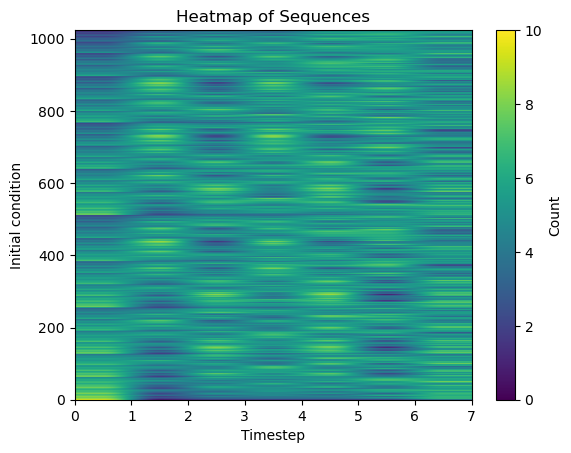

In [39]:
SEED =1
print("Starting...")
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.threading.set_inter_op_parallelism_threads(1)
gridsize=10
x_values = [seq for seq in itertools.product("01", repeat=gridsize)]
x_values = [[int(bit) for bit in seq] for seq in x_values]

MEMORY_CONSTANT=3
num_classes = 2  
sequence_length=MEMORY_CONSTANT*2
 
gol = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

gol.set_rule_number(30)

sequences= np.array(gol.generate_training_data_sequences(x_values,sequence_length=sequence_length))

print(sequences.shape)
collapsed_sequences=collapse_sequences(sequences)
print(collapsed_sequences.shape)
#Some visualization of the dataset
 
collapsed_sequences_2d = np.squeeze(collapsed_sequences, axis=-1)

# Some visualization of the dataset
plt.imshow(collapsed_sequences_2d, cmap='viridis', origin='upper',
           extent=[0, collapsed_sequences_2d.shape[1], 0, collapsed_sequences_2d.shape[0]],
           aspect='auto', vmin=0, vmax=gridsize)



plt.colorbar(label='Count')
plt.xlabel("Timestep")
plt.ylabel("Initial condition")
plt.title('Heatmap of Sequences')
plt.savefig("Heatmap_rule30")

np.random.shuffle(sequences)

x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
y_sequence=sequences[:,MEMORY_CONSTANT*2]
x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
 
Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), num_classes))
x_train = x_sequence   
y_train= Y_val_onehot
loss = lambda x, y: tf.keras.losses.categorical_crossentropy(tf.reshape(x, shape=(-1, num_classes)),                                                         tf.reshape(y, shape=(-1, num_classes)) ,from_logits=True)
y_train_full= Y_val_onehot



split_ratio = 0.25
x_train_reshaped=[]
for data_point in x_train:
    x_train_reshaped.append(np.transpose(data_point))
x_train_reshaped=np.array(x_train_reshaped)  
 
split_point_x = int(len(x_train_reshaped) * split_ratio)
split_point_y = int(len(y_train_full) * split_ratio)
 
x_test = x_train_reshaped[:split_point_x]
y_test = y_train_full[:split_point_y]
x_train = x_train_reshaped[split_point_x:]
y_train = y_train_full[split_point_y:]
split_ratio = 0.5
 
split_point_x = int(len(x_test) * split_ratio)
split_point_y = int(len(y_test) * split_ratio)

 
x_val = x_test[:split_point_x]
y_val = y_test[:split_point_x]
x_test = x_test[split_point_x:]
y_test = y_test[split_point_x:]
 
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape, "x_val shape:", x_val.shape, "y_val shape:", y_val.shape, "x_test shape:", x_test.shape, "y_test shape:", y_test.shape)


num_filters=1


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_28 (SimpleRNN)   (None, 10, 1)             5         
                                                                 
 reshape_25 (Reshape)        (None, 10, 1)             0         
                                                                 
 dense_24 (Dense)            (None, 10, 2)             4         
                                                                 
 wraparound1d_4 (Wraparound1  (None, 12, 2)            0         
 D)                                                              
                                                                 
 conv1d_14 (Conv1D)          (None, 10, 10)            70        
                                                                 
 conv1d_15 (Conv1D)          (None, 10, 10)            110       
                                                     

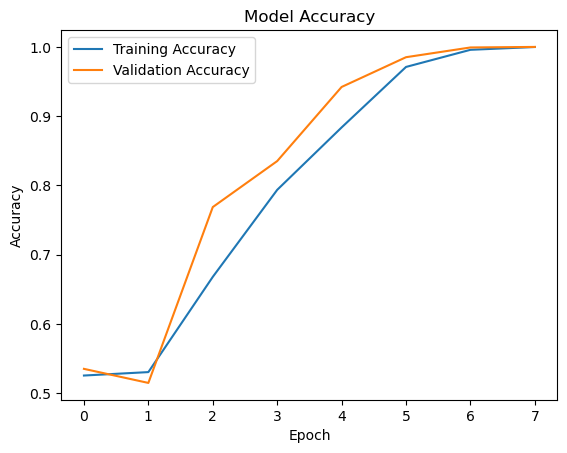

In [42]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(gridsize,MEMORY_CONSTANT  )))  
#model.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=MEMORY_CONSTANT, padding='valid',
#                               kernel_initializer=keras.initializers.ones(), 
#                                        bias_initializer=tf.keras.initializers.Zeros(),trainable=True,use_bias=True,
#                                activation="relu"
#                                 ))

model.add(tf.keras.layers.SimpleRNN(units=1, return_sequences=True, activation='relu',
                               kernel_initializer=tf.keras.initializers.Ones()))
    
model.add(tf.keras.layers.Reshape((gridsize,1)))
model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))
model.add(Wraparound1D(padding=1))
model.add(tf.keras.layers.Conv1D(gridsize, 3, activation='relu', padding='valid',  trainable=True) )

model.add(tf.keras.layers.Conv1D(gridsize, 1, activation='relu', padding='same'))
 
model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=loss, metrics=['accuracy'])
model.summary()
early_stopping_callback = CustomCallback()
x_train_reshaped=[]
 
x_train_reshaped=tf.convert_to_tensor(x_train , dtype=tf.float32)

history=model.fit(x_train_reshaped, y_train, 
          validation_data=(x_val, y_val)
          ,epochs=15
        , batch_size=1,callbacks=[early_stopping_callback]) 
model.evaluate(x_test,y_test)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.savefig('accuracy_plot.png')
plt.show()

1/1 [==============================] - 0s 14ms/step
[[0 1 1]
 [0 0 0]
 [0 0 0]
 [0 1 1]
 [1 1 1]
 [1 0 0]
 [0 1 1]
 [0 1 1]
 [1 1 1]
 [1 0 0]]
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


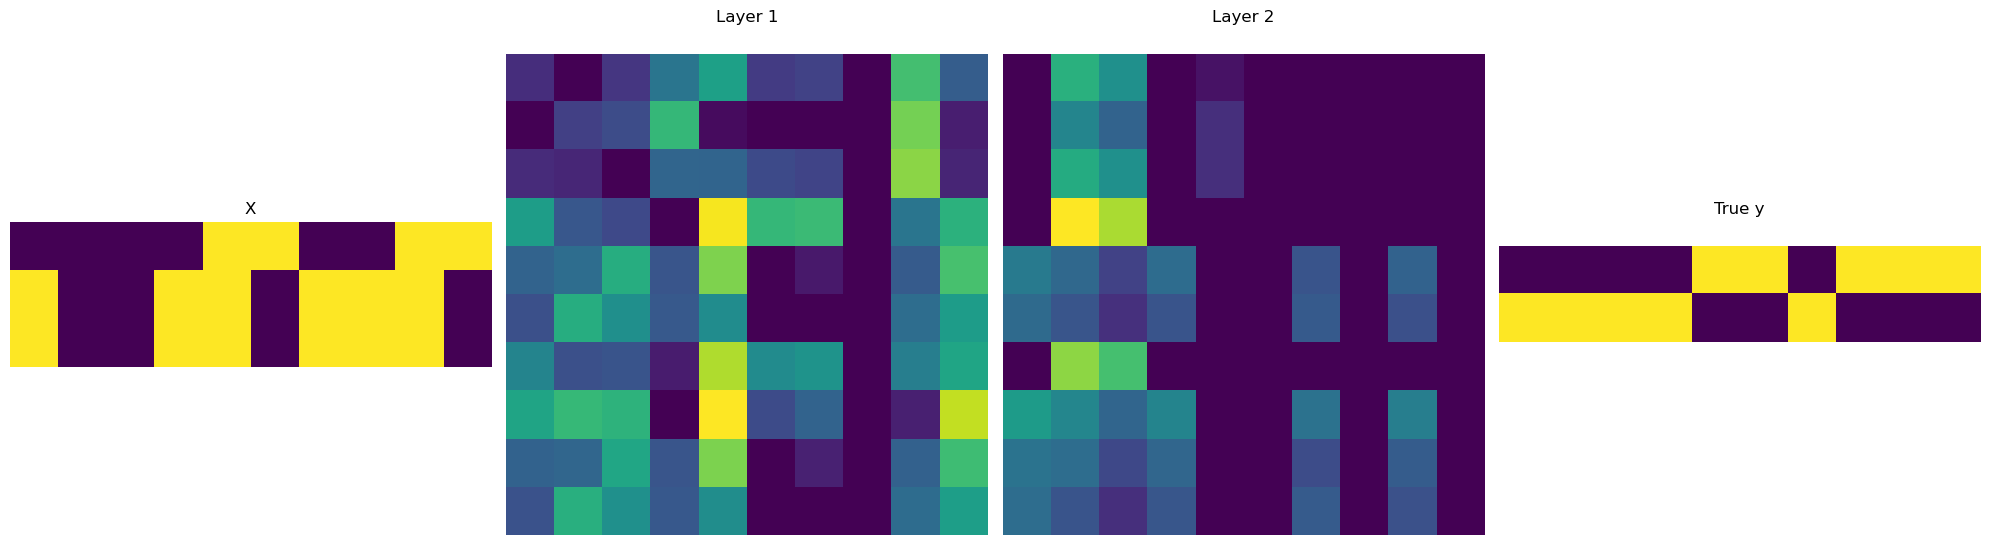

1/1 [==============================] - 0s 15ms/step
[[1 0 1]
 [1 1 1]
 [0 1 1]
 [0 0 0]
 [1 0 0]
 [0 0 0]
 [0 1 1]
 [1 1 1]
 [1 0 0]
 [1 0 1]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


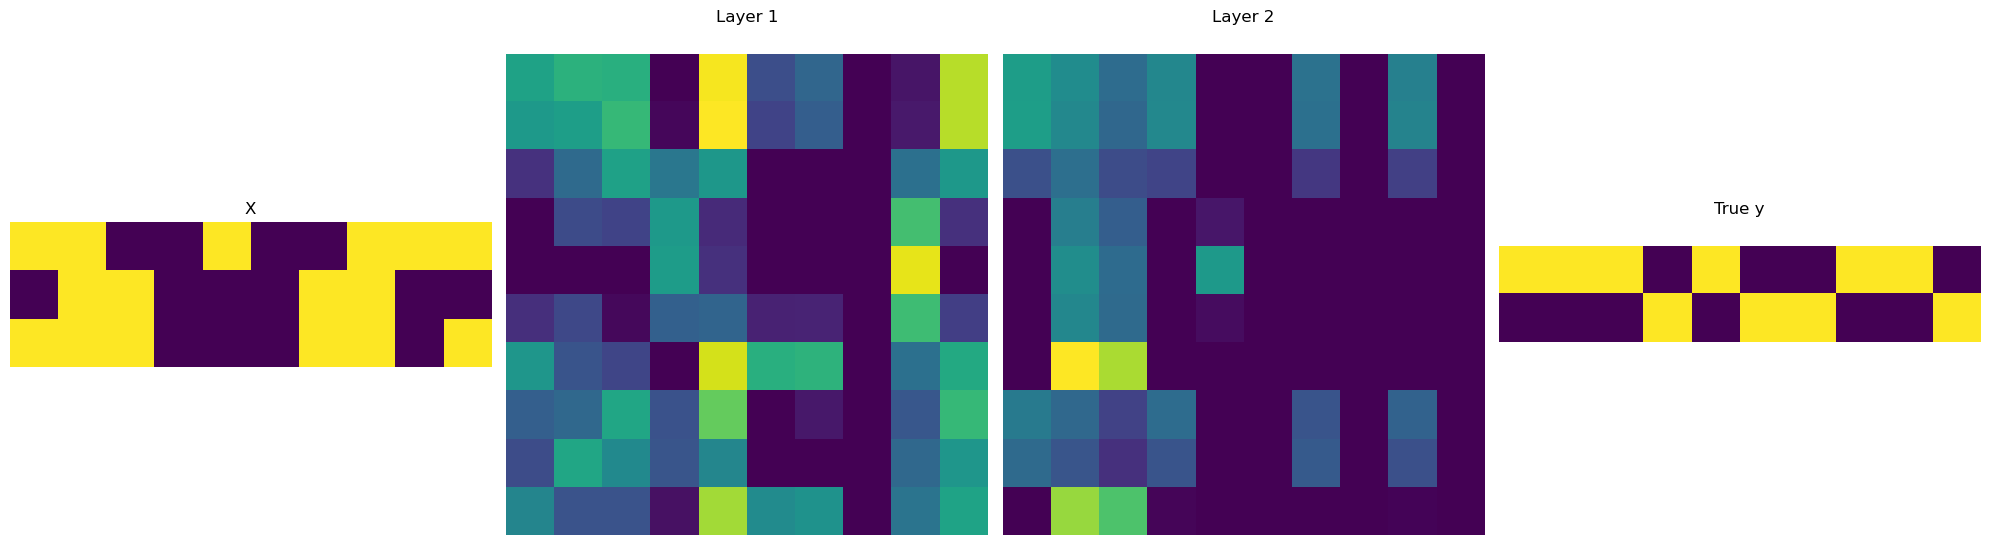

1/1 [==============================] - 0s 15ms/step
[[1 1 1]
 [0 1 0]
 [0 1 0]
 [1 1 1]
 [0 0 1]
 [0 0 1]
 [1 1 1]
 [0 0 0]
 [1 1 1]
 [0 0 0]]
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]], shape=(10, 2), dtype=float32)


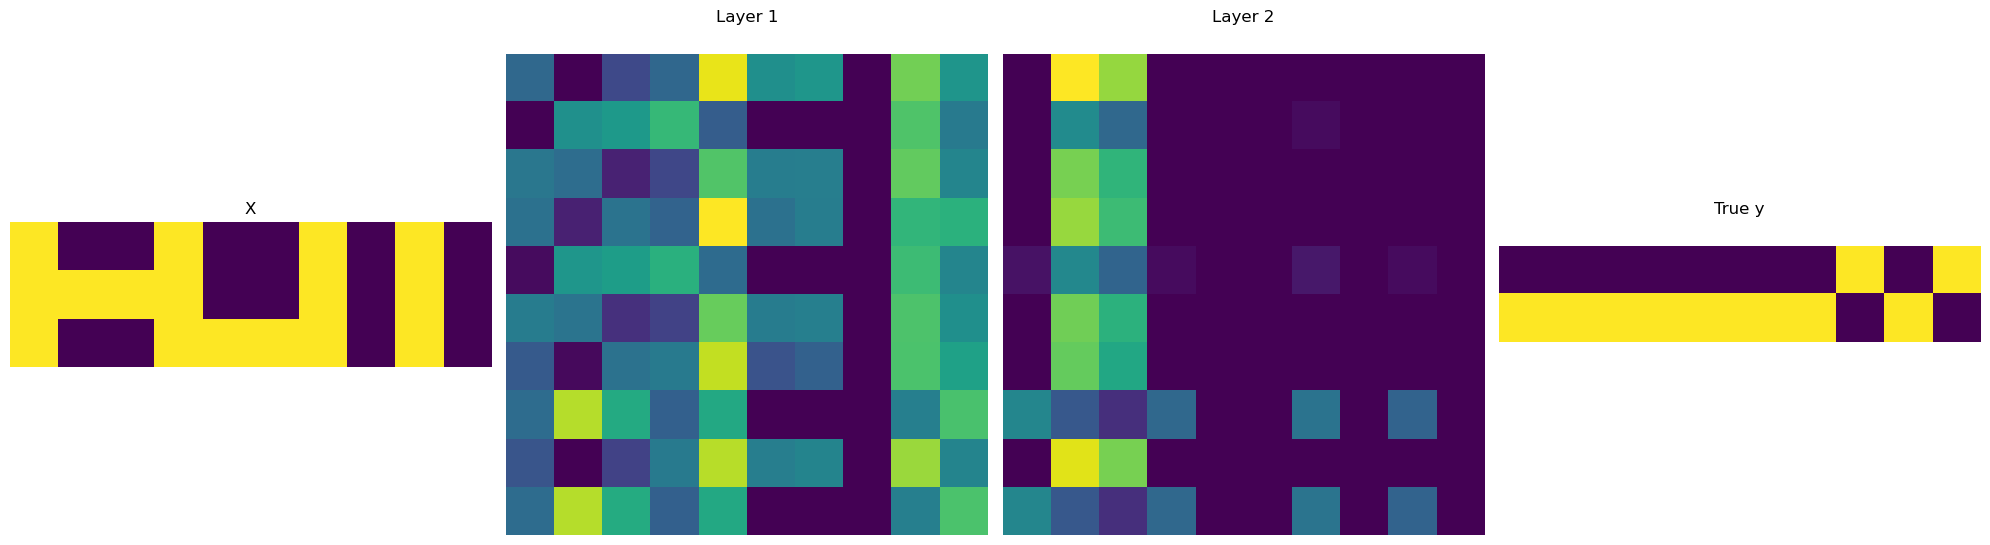

1/1 [==============================] - 0s 14ms/step
[[0 1 1]
 [1 1 1]
 [1 0 0]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]
 [0 1 0]
 [1 0 1]
 [0 0 0]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]], shape=(10, 2), dtype=float32)


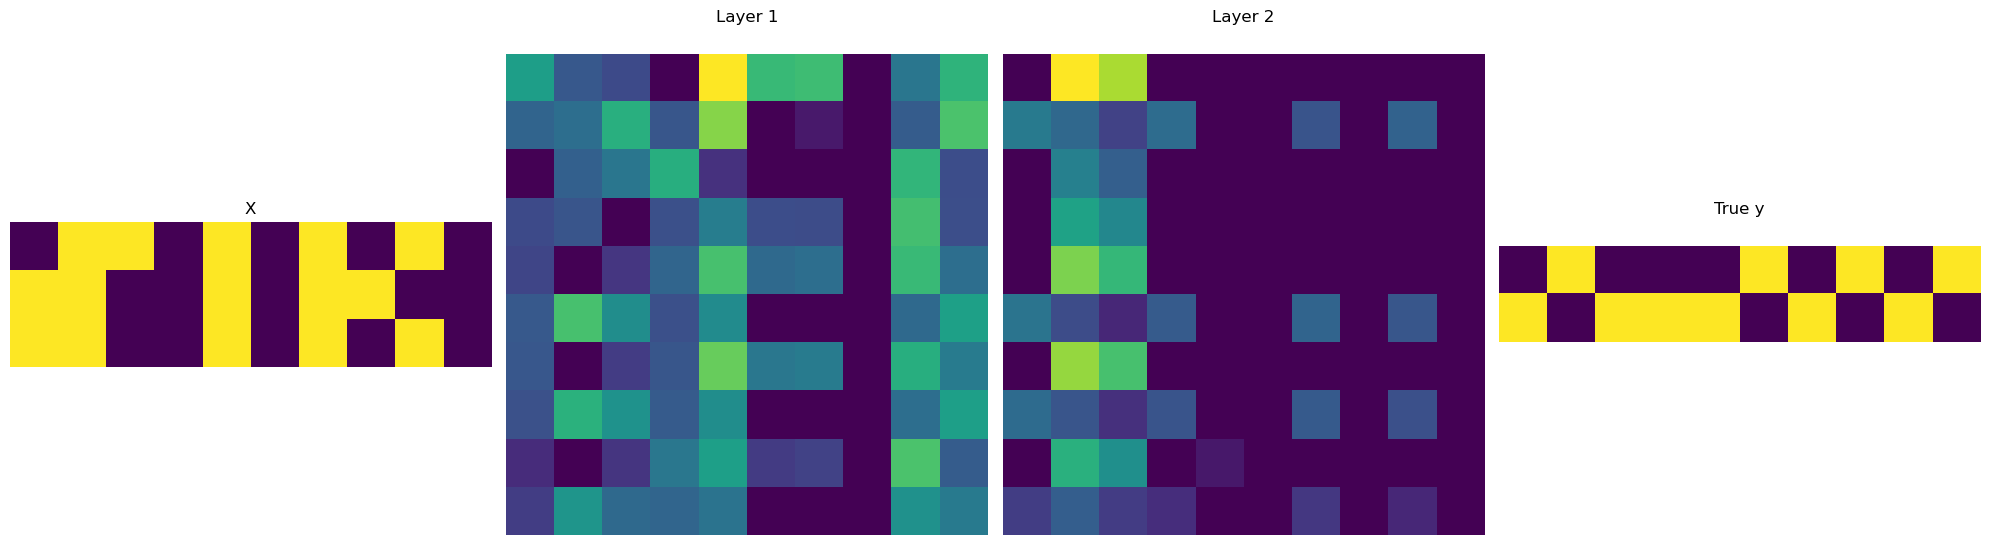

1/1 [==============================] - 0s 15ms/step
[[0 0 1]
 [1 1 1]
 [1 0 0]
 [0 0 0]
 [1 1 1]
 [1 0 0]
 [0 0 0]
 [1 1 1]
 [1 0 1]
 [1 0 0]]
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


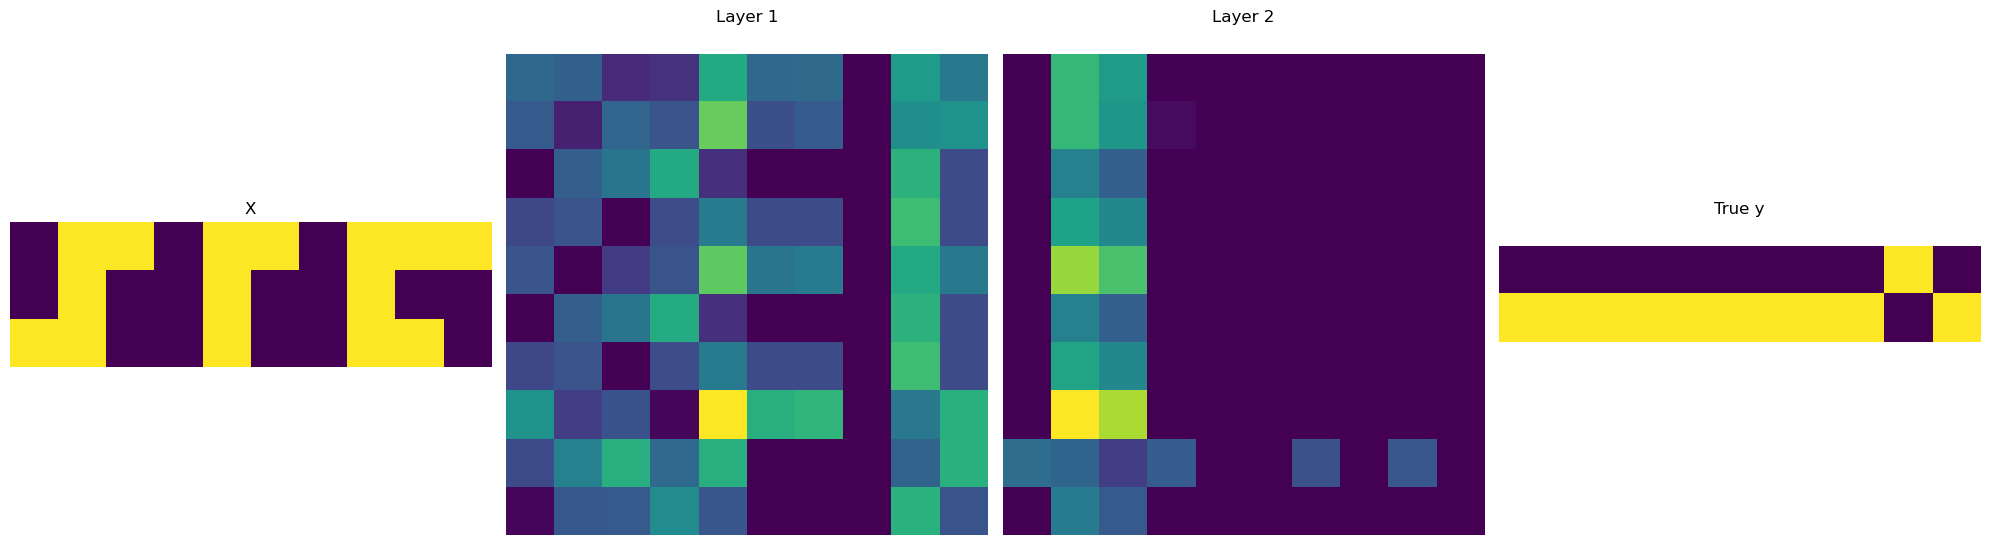

1/1 [==============================] - 0s 15ms/step
[[1 0 0]
 [0 0 1]
 [1 1 1]
 [0 0 0]
 [1 1 1]
 [1 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


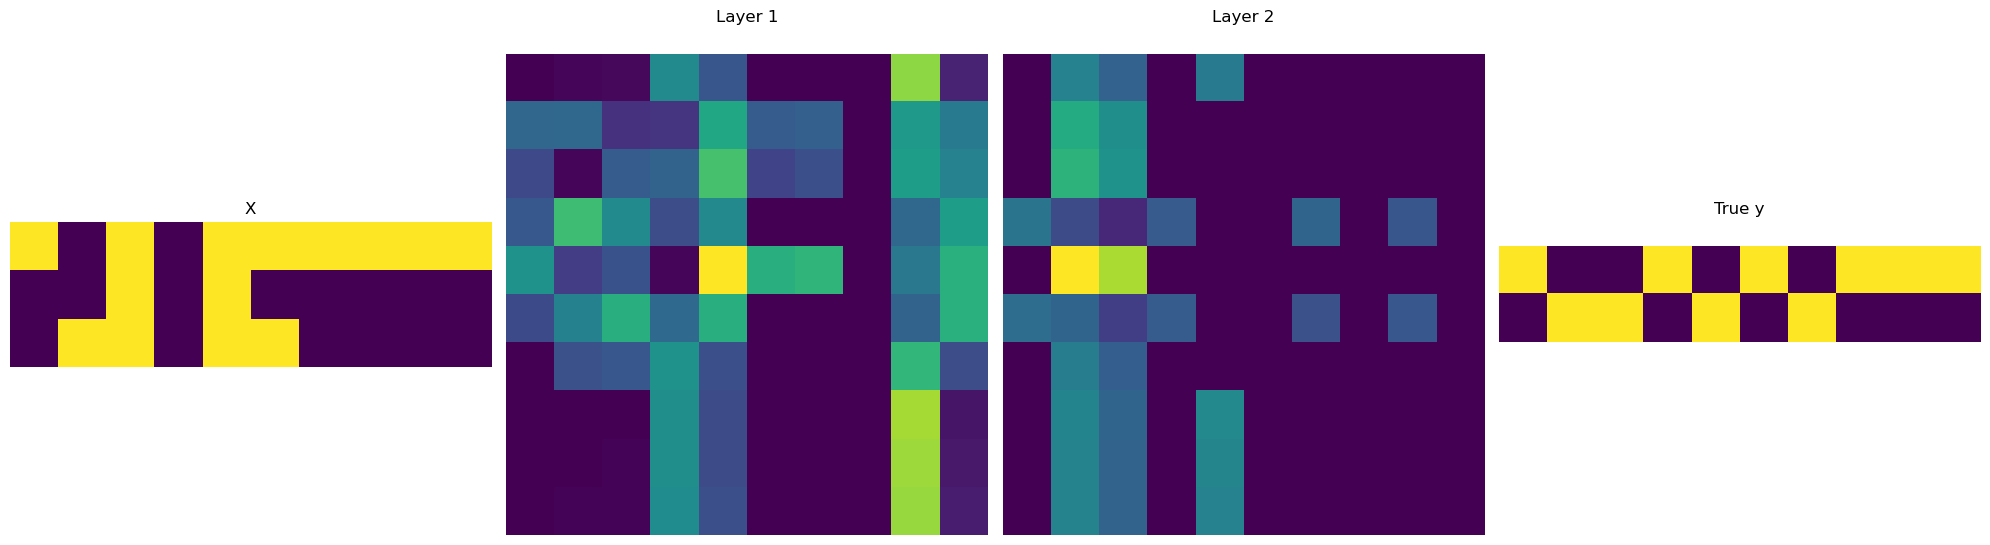

1/1 [==============================] - 0s 15ms/step
[[0 1 1]
 [1 1 0]
 [1 1 0]
 [1 0 0]
 [1 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 1]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


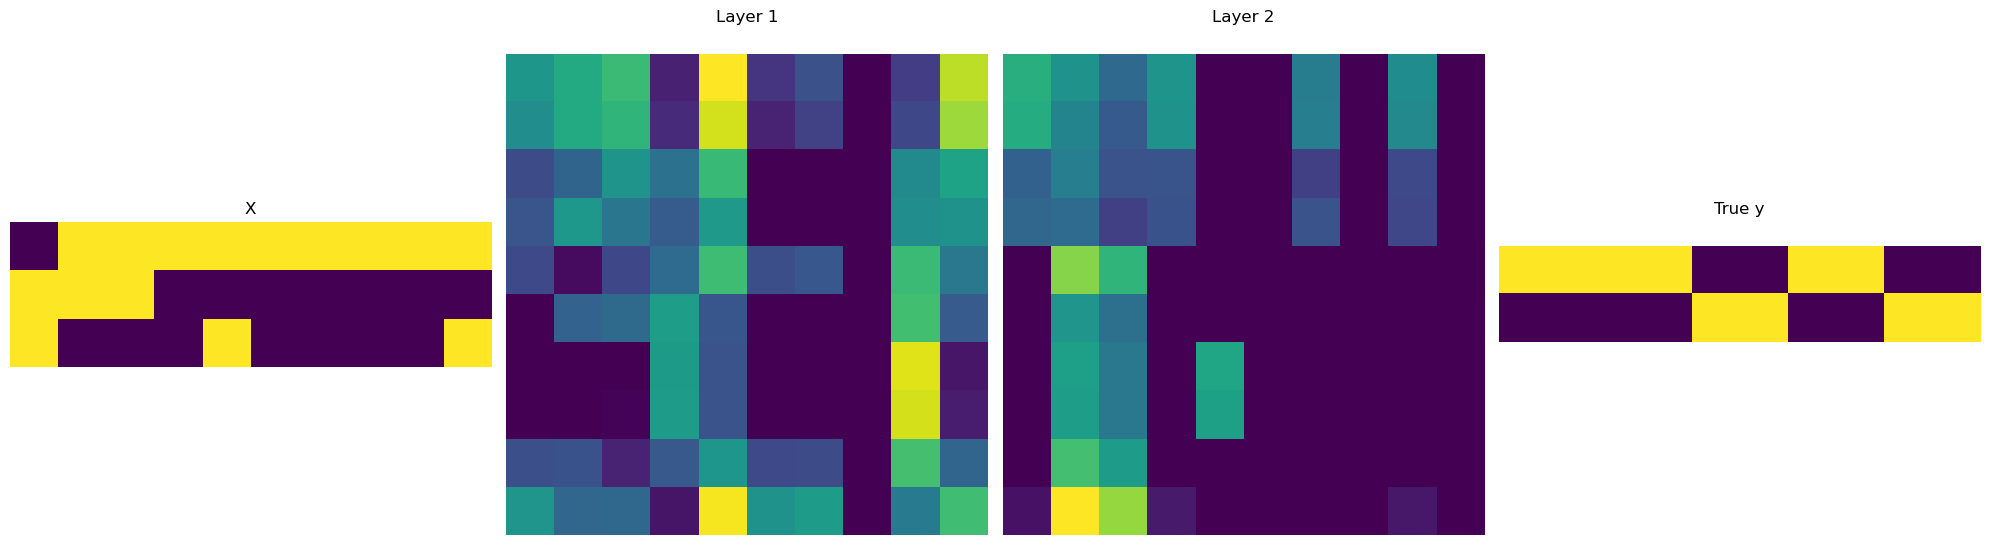

1/1 [==============================] - 0s 16ms/step
[[1 1 1]
 [1 1 0]
 [0 0 1]
 [0 0 1]
 [1 1 1]
 [0 1 0]
 [1 0 1]
 [0 0 0]
 [0 0 0]
 [0 0 1]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


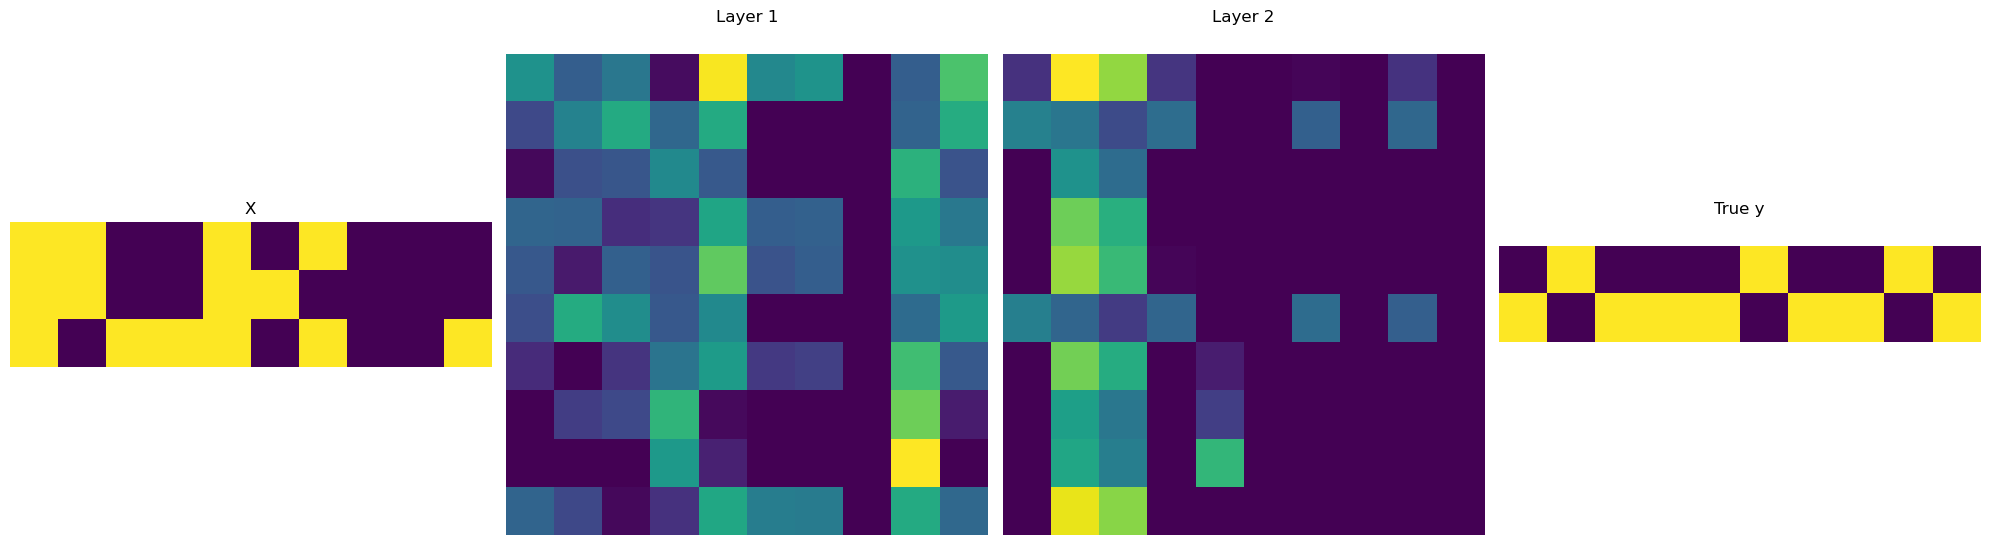

1/1 [==============================] - 0s 15ms/step
[[1 0 1]
 [1 0 0]
 [0 0 1]
 [1 1 1]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


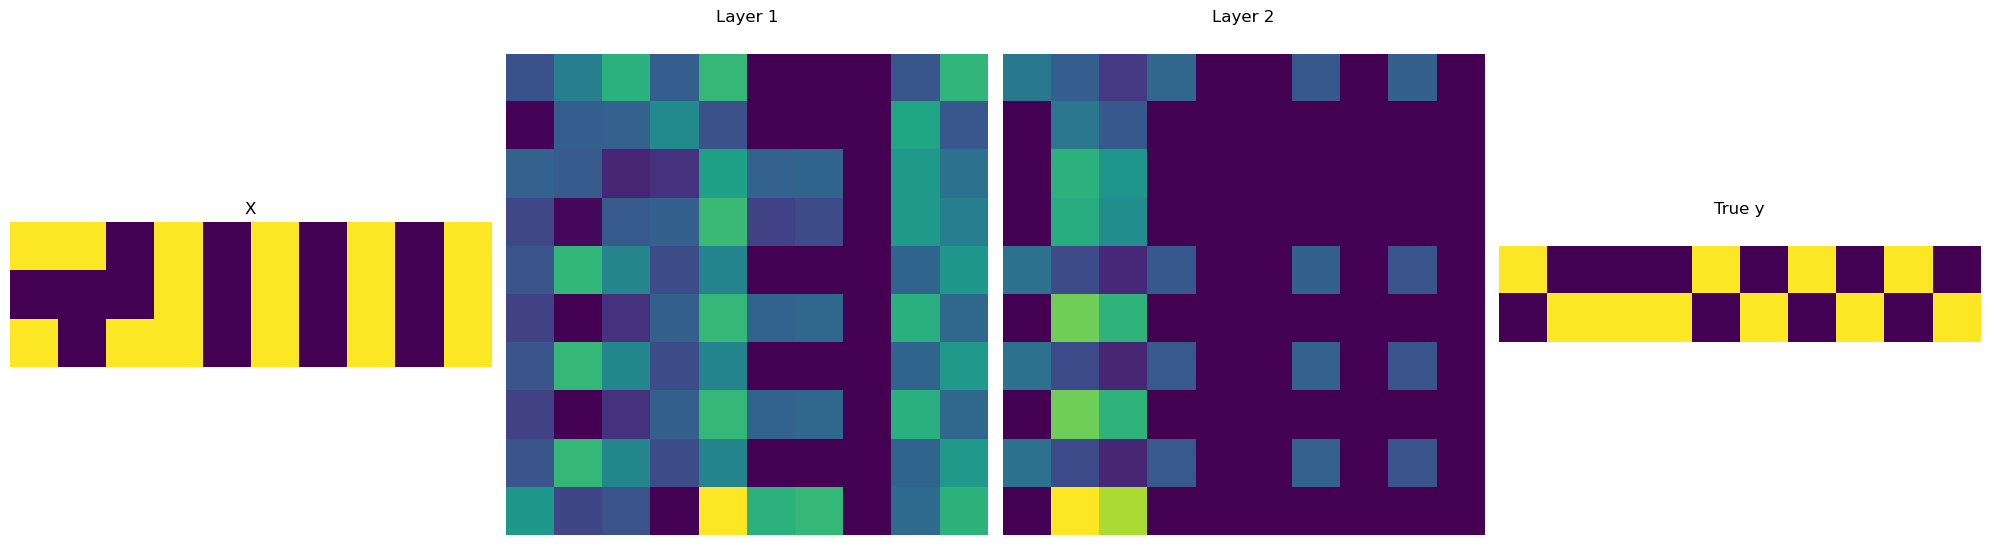

1/1 [==============================] - 0s 15ms/step
[[0 0 0]
 [1 0 0]
 [0 1 1]
 [1 1 1]
 [1 0 0]
 [1 0 1]
 [0 0 1]
 [1 1 1]
 [1 0 0]
 [0 1 1]]
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


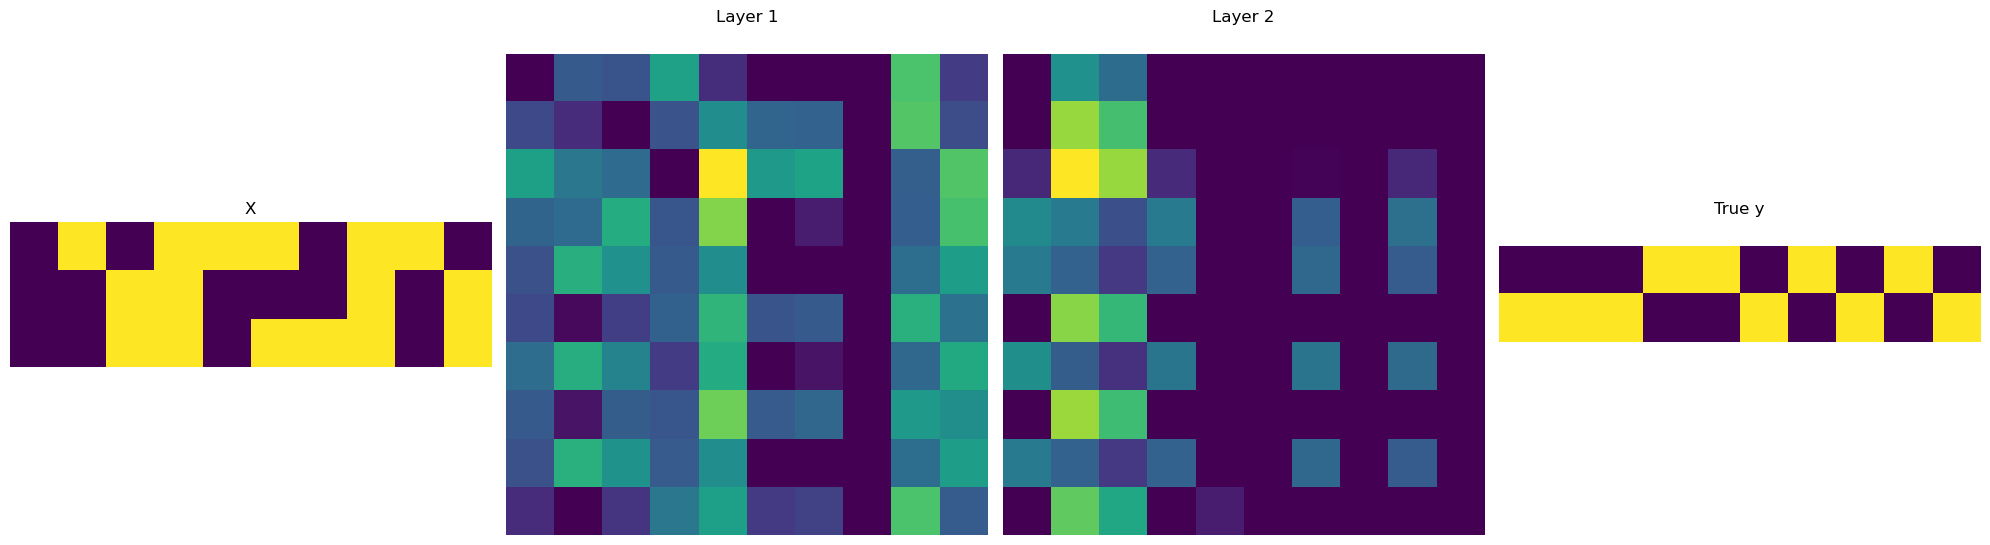

1/1 [==============================] - 0s 14ms/step
[[0 0 0]
 [0 0 0]
 [0 1 1]
 [1 1 1]
 [1 0 0]
 [0 1 0]
 [1 0 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


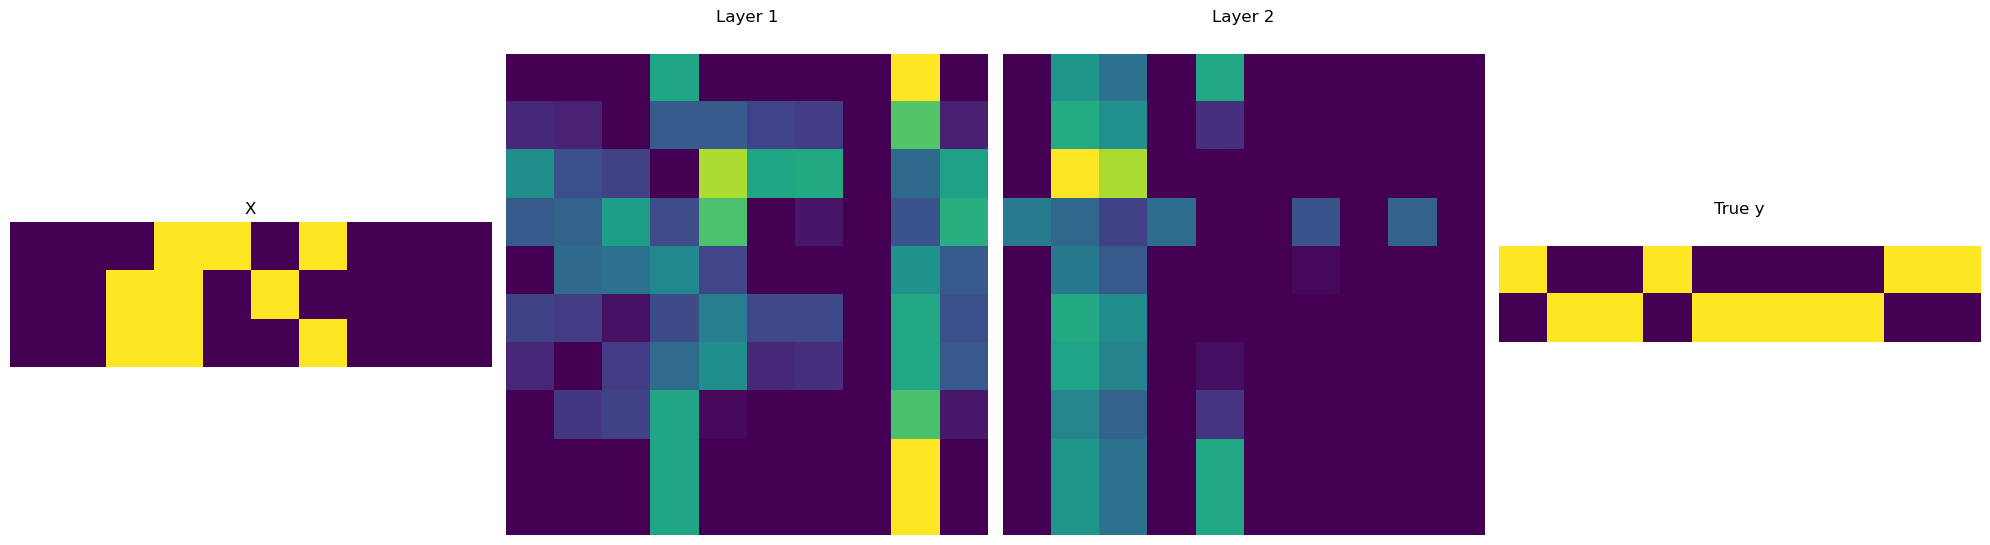

1/1 [==============================] - 0s 15ms/step
[[1 0 1]
 [0 1 1]
 [0 1 0]
 [0 1 0]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]
 [1 0 1]
 [1 0 0]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


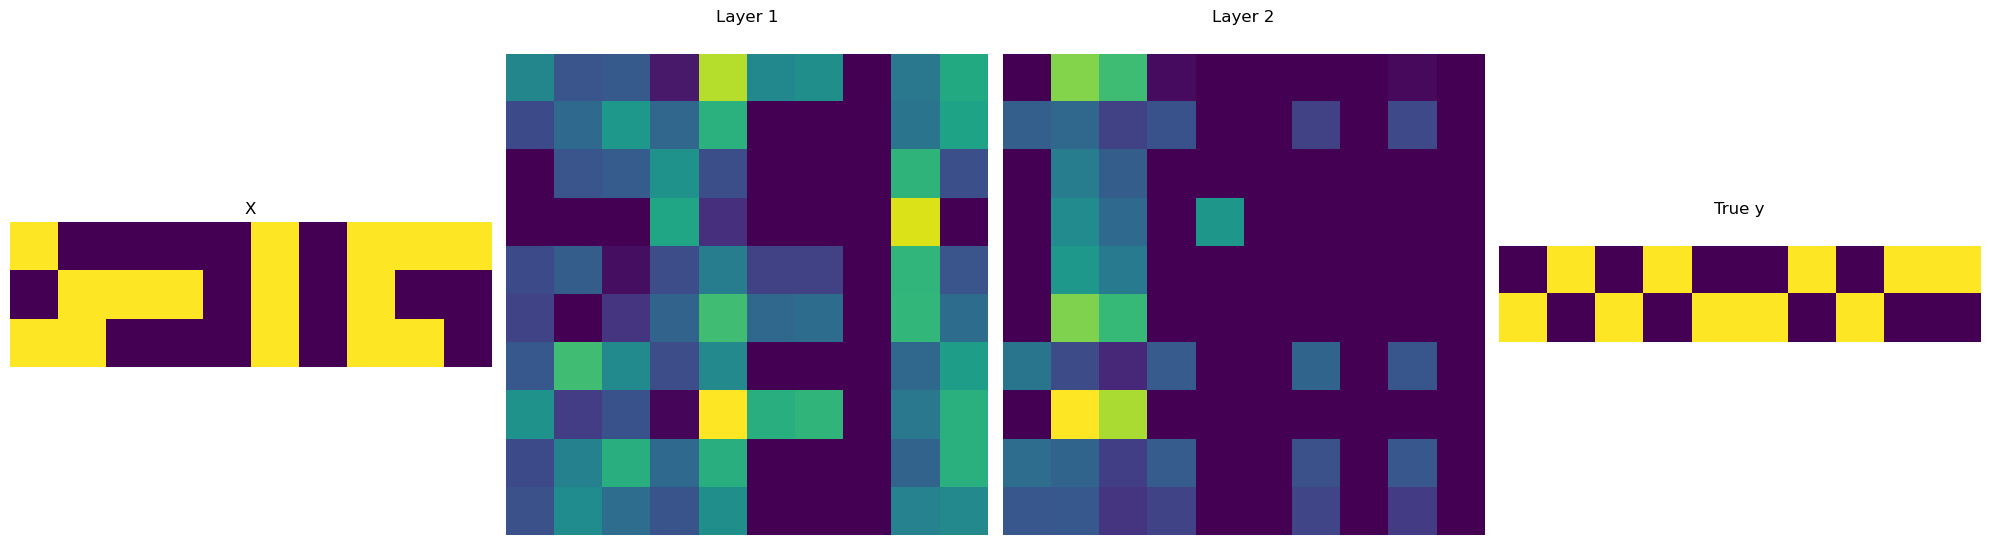

1/1 [==============================] - 0s 14ms/step
[[0 1 0]
 [0 1 0]
 [1 1 0]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]
 [0 1 0]
 [0 1 0]
 [1 1 0]]
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


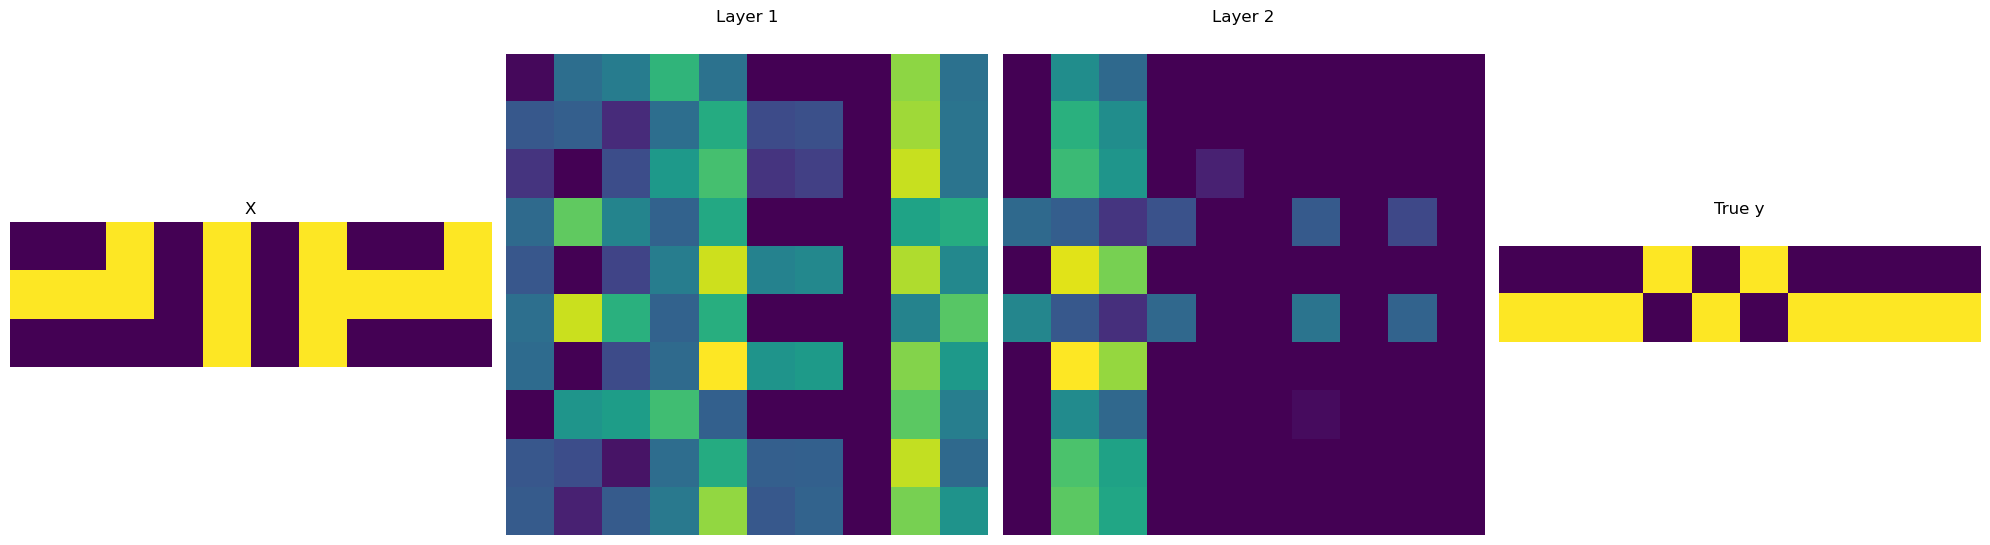

1/1 [==============================] - 0s 15ms/step
[[1 0 1]
 [1 0 1]
 [1 1 1]
 [0 1 1]
 [0 0 0]
 [0 1 1]
 [1 1 1]
 [0 0 1]
 [0 0 1]
 [1 1 1]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


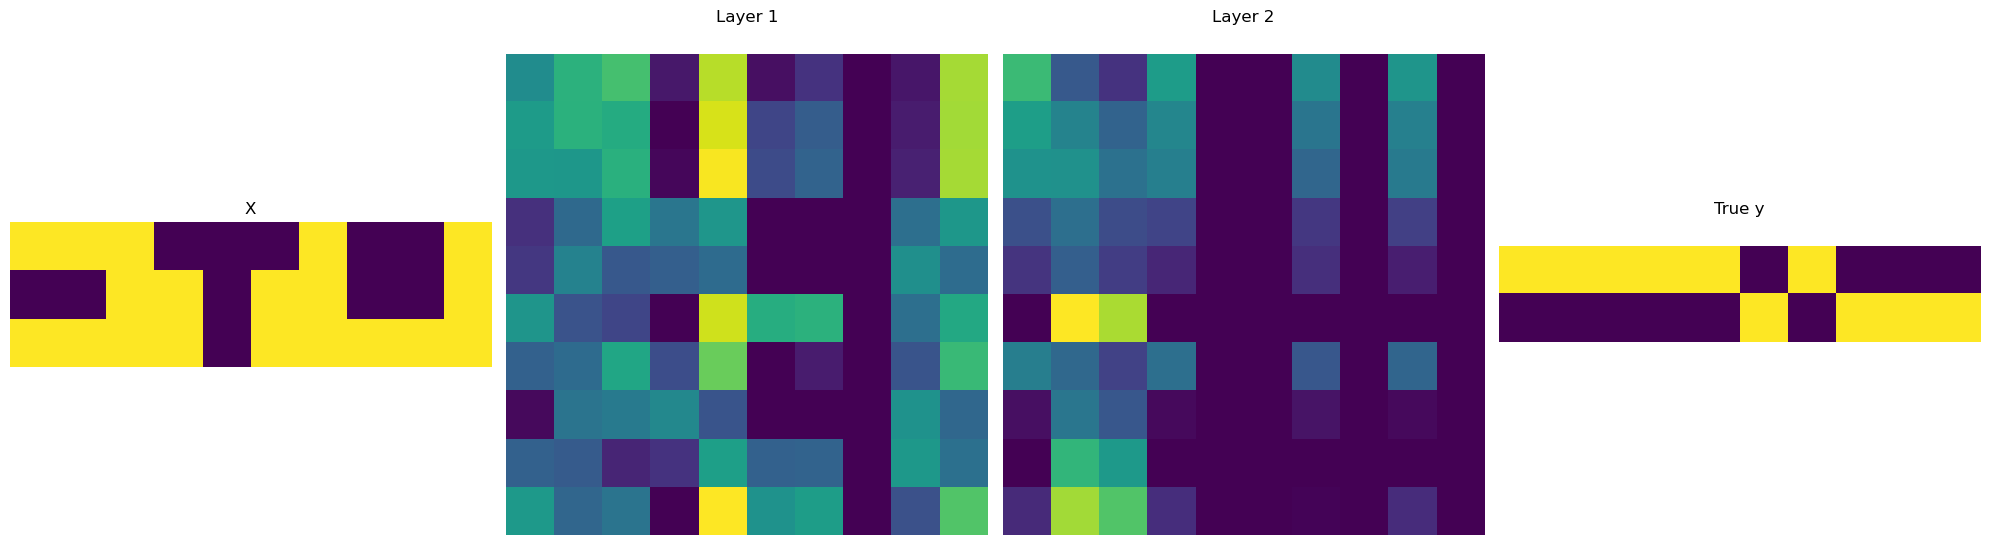

1/1 [==============================] - 0s 17ms/step
[[1 0 0]
 [0 0 0]
 [1 1 1]
 [0 1 0]
 [1 1 0]
 [1 1 0]
 [1 0 0]
 [0 1 0]
 [1 1 0]
 [1 1 0]]
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]], shape=(10, 2), dtype=float32)


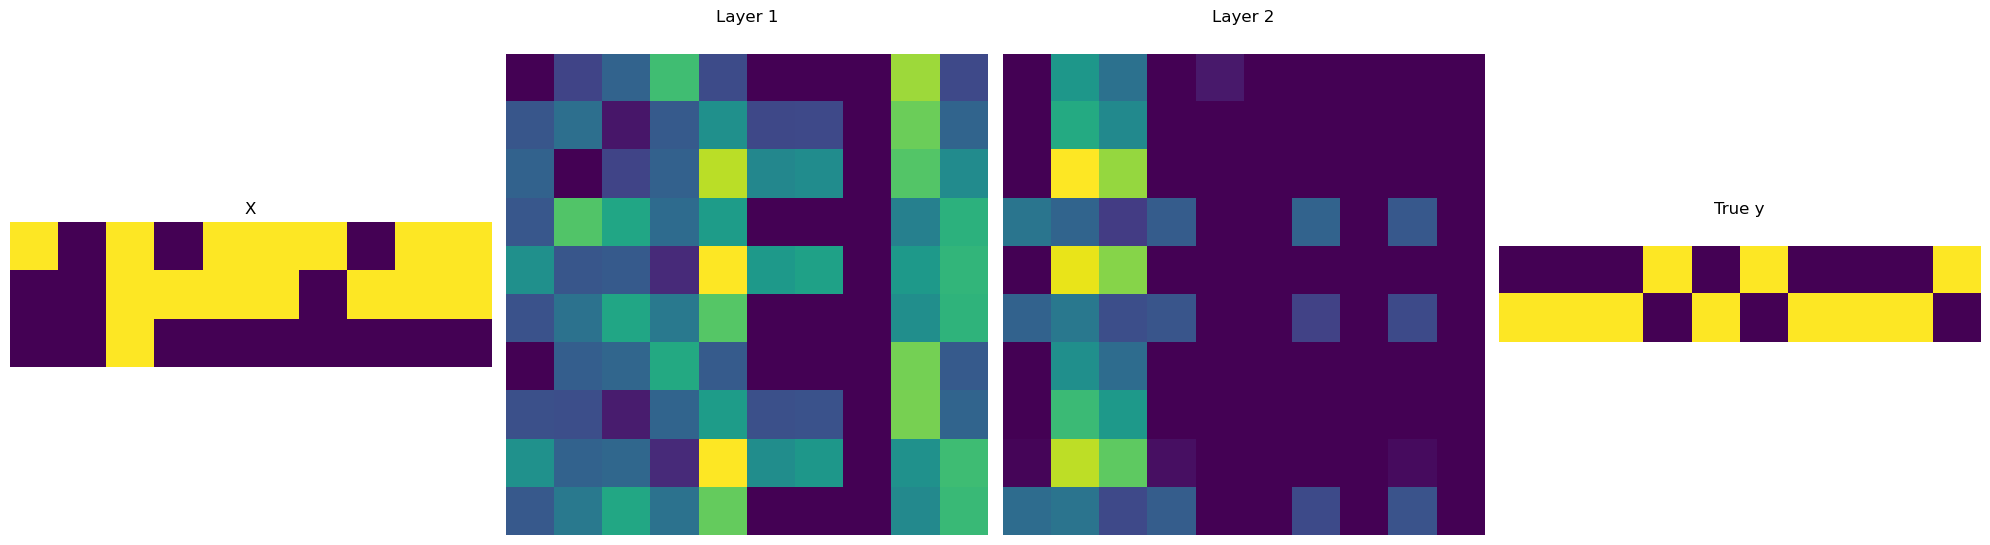

1/1 [==============================] - 0s 15ms/step
[[1 1 1]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]
 [0 1 0]
 [1 1 0]
 [1 1 0]
 [1 0 0]
 [0 0 0]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


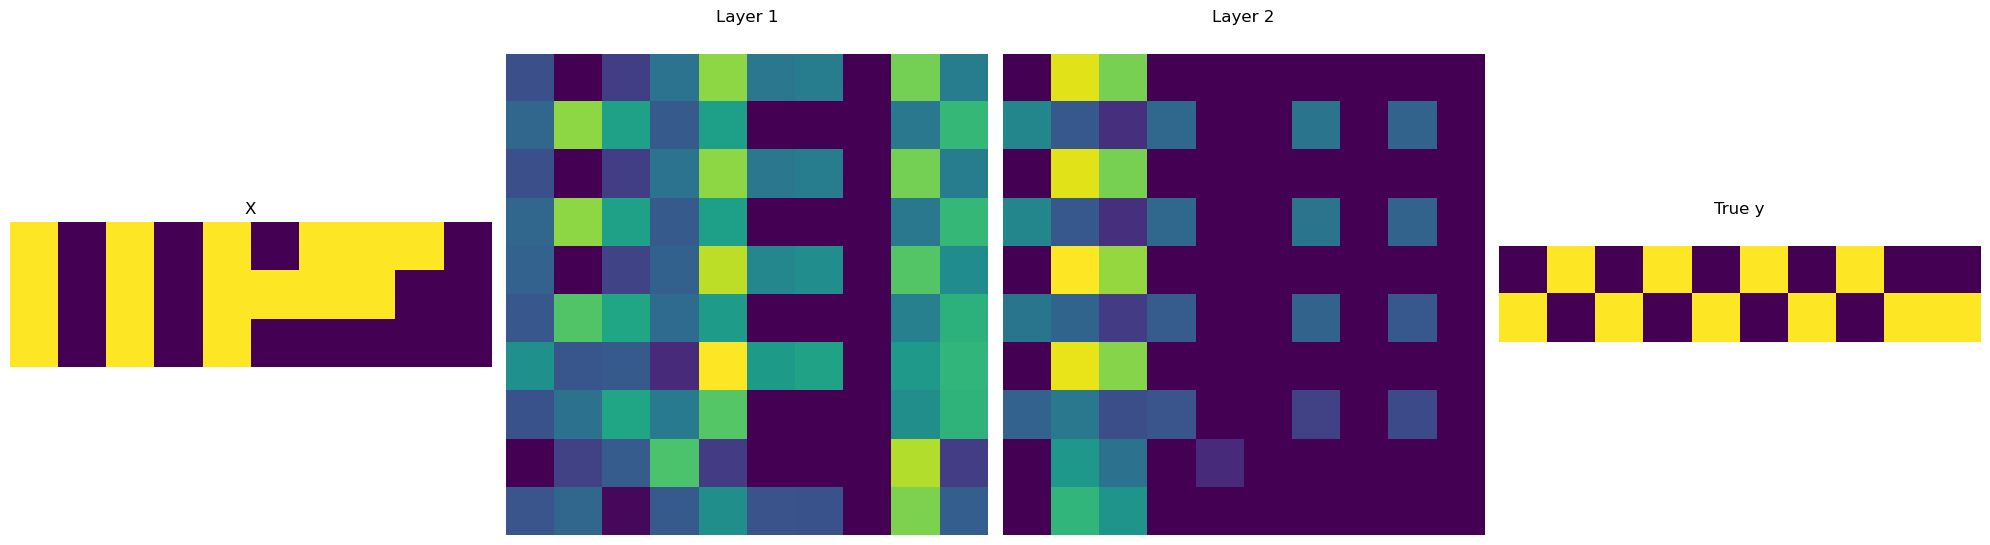

1/1 [==============================] - 0s 18ms/step
[[0 0 0]
 [0 0 0]
 [0 1 1]
 [1 1 1]
 [1 0 0]
 [0 0 0]
 [1 1 1]
 [0 1 0]
 [0 0 1]
 [0 0 0]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


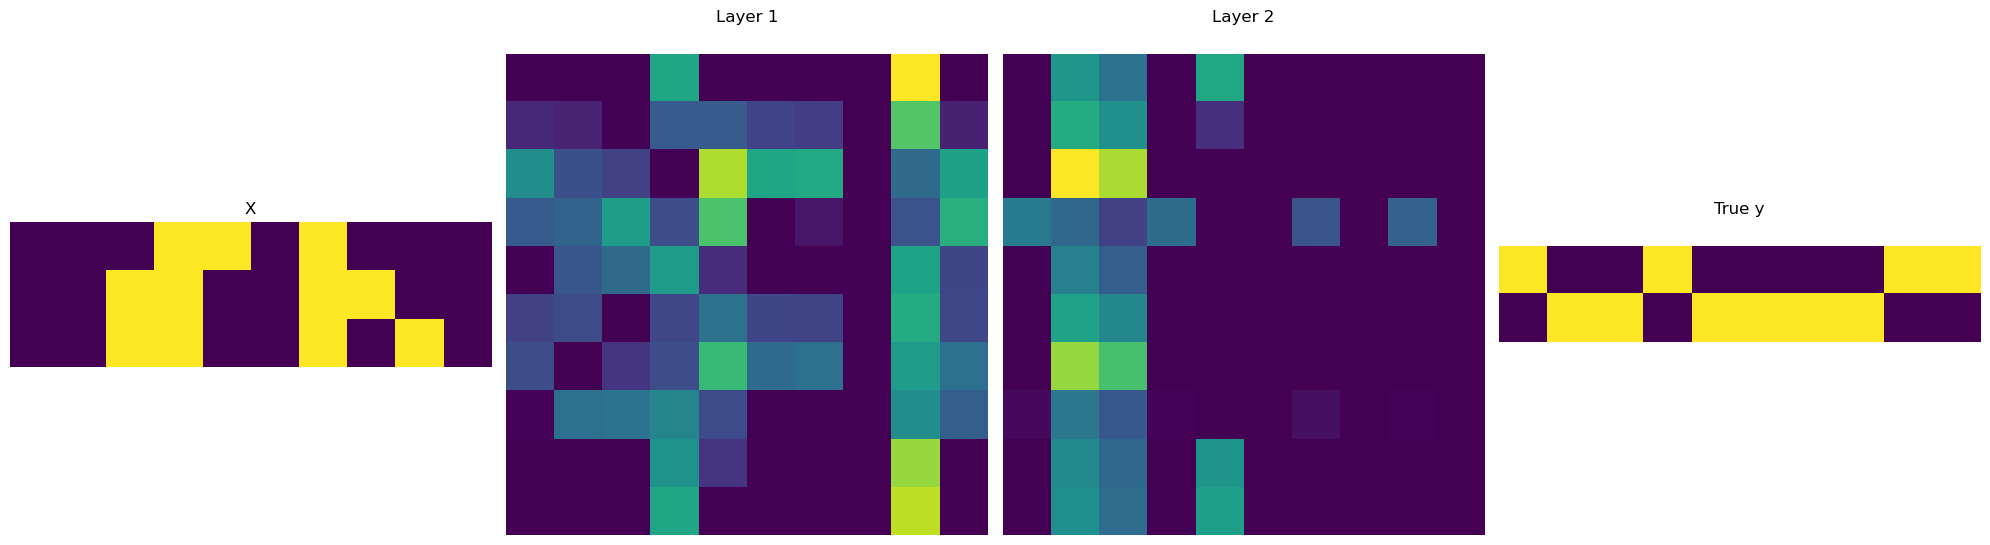

1/1 [==============================] - 0s 16ms/step
[[0 1 1]
 [0 0 1]
 [0 1 1]
 [1 1 0]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


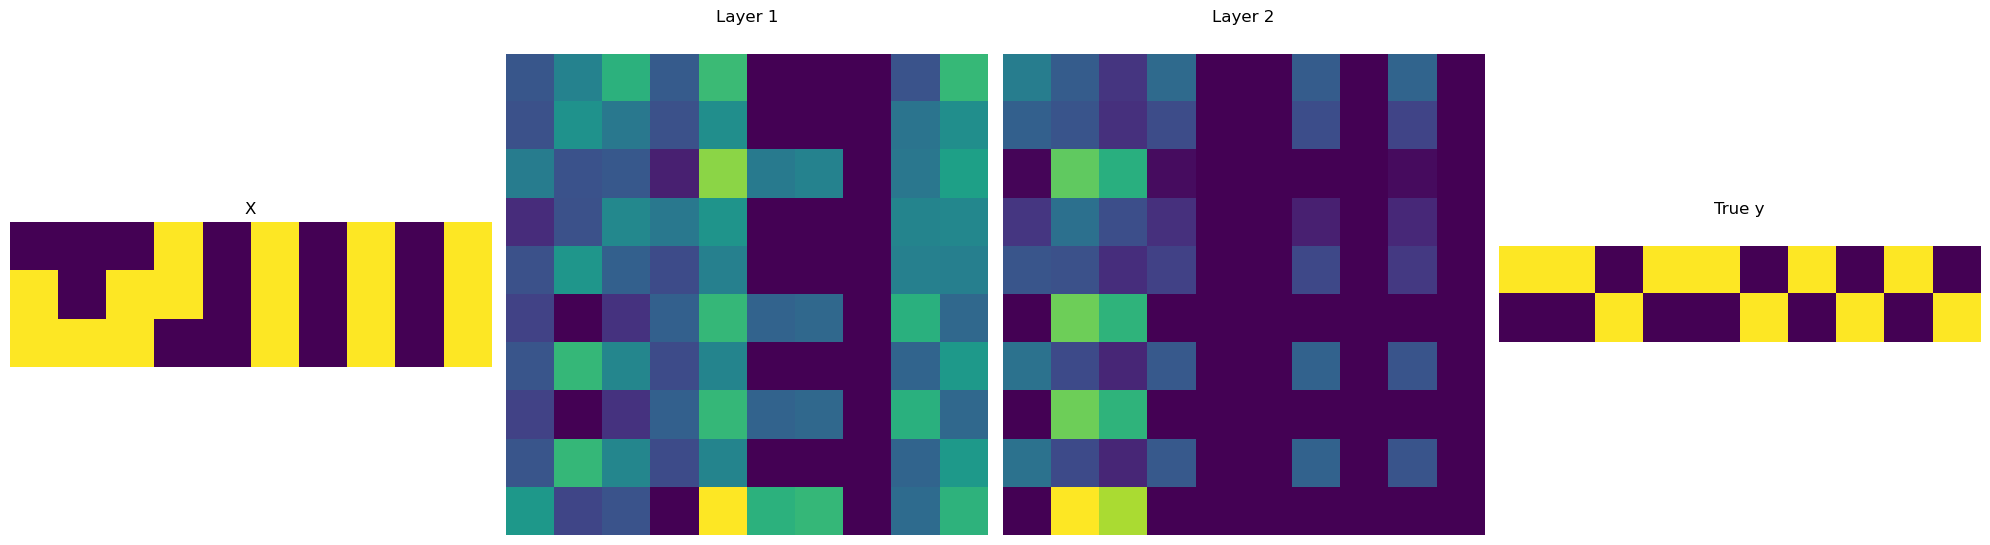

1/1 [==============================] - 0s 17ms/step
[[0 0 0]
 [1 1 1]
 [1 0 1]
 [1 0 0]
 [1 0 1]
 [0 1 1]
 [0 1 0]
 [1 1 0]
 [0 0 0]
 [1 1 1]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


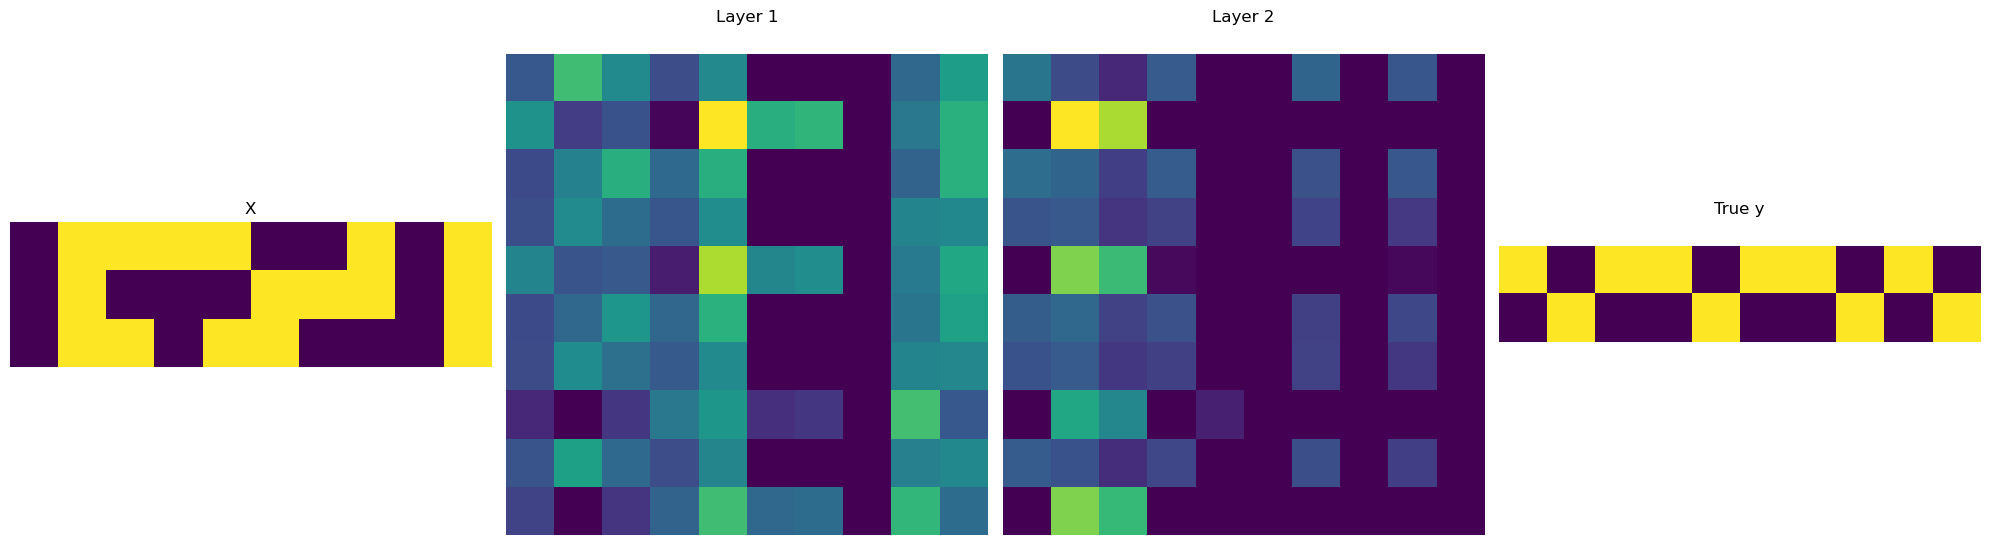

1/1 [==============================] - 0s 15ms/step
[[0 0 0]
 [1 1 1]
 [0 1 0]
 [1 1 0]
 [1 1 0]
 [1 0 0]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


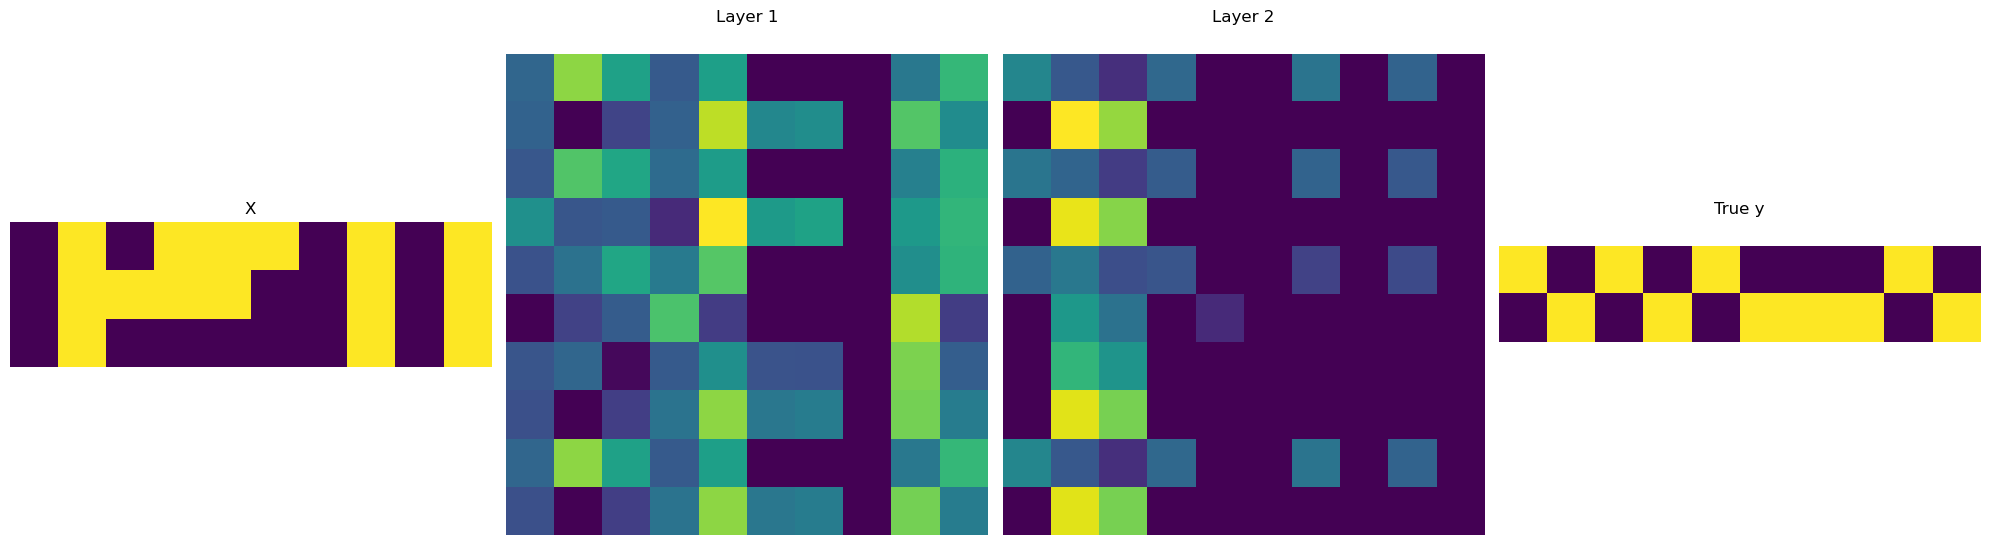

In [44]:
from tensorflow.keras.models import Model


# List to store the output of convolutional layers
conv_layer_outputs = [layer.output for layer in model.layers if "conv" in layer.name.lower()]

# Create a new model that outputs the activations for every convolutional layer
activation_model = Model(inputs=model.input, outputs=conv_layer_outputs)

for ind, x in enumerate(x_train[0:20]):
    x_to_visualize = np.expand_dims(x, axis=0)

    # Get activations and round them
    activations = activation_model.predict(x_to_visualize)
   # activations = [np.round(act) for act in activations]

    # Get the output from the original model and round it
   # model_output = np.round(model.predict(x_to_visualize))
    model_output =model.predict(x_to_visualize)
    # Create a subplot for input + last two activations + output
    num_layers = len(activations)
    fig, axes = plt.subplots(1,4, figsize=(20, 20))

    # Plot input
    axes[0].imshow(x_to_visualize[0, :].transpose(), cmap="viridis")
    axes[0].set_title("X")
    axes[0].axis("off")

    # Loop through and plot the last two rounded activations
    for i, activation in enumerate(activations[-2:]):
        ax = axes[i + 1]
        ax.matshow(activation[0, :, :], cmap="viridis")
        ax.set_title(f"Layer {num_layers - 1 + i}")
        ax.axis("off")
    
    # prediction
   #axes[-2].matshow(model_output.transpose(), cmap="viridis")
   #axes[-2].set_title("Prediction")
   #axes[-2].axis("off")
    print(x_train[ind])
    print(y_train[ind])
    axes[-1].matshow(np.array(y_train[ind]).transpose(), cmap="viridis")
    axes[-1].set_title("True y")
    axes[-1].axis("off")

    plt.tight_layout()

    plt.savefig("Recurrentmem3activations" + str(ind) + ".png", dpi=300, bbox_inches="tight")
    plt.show()


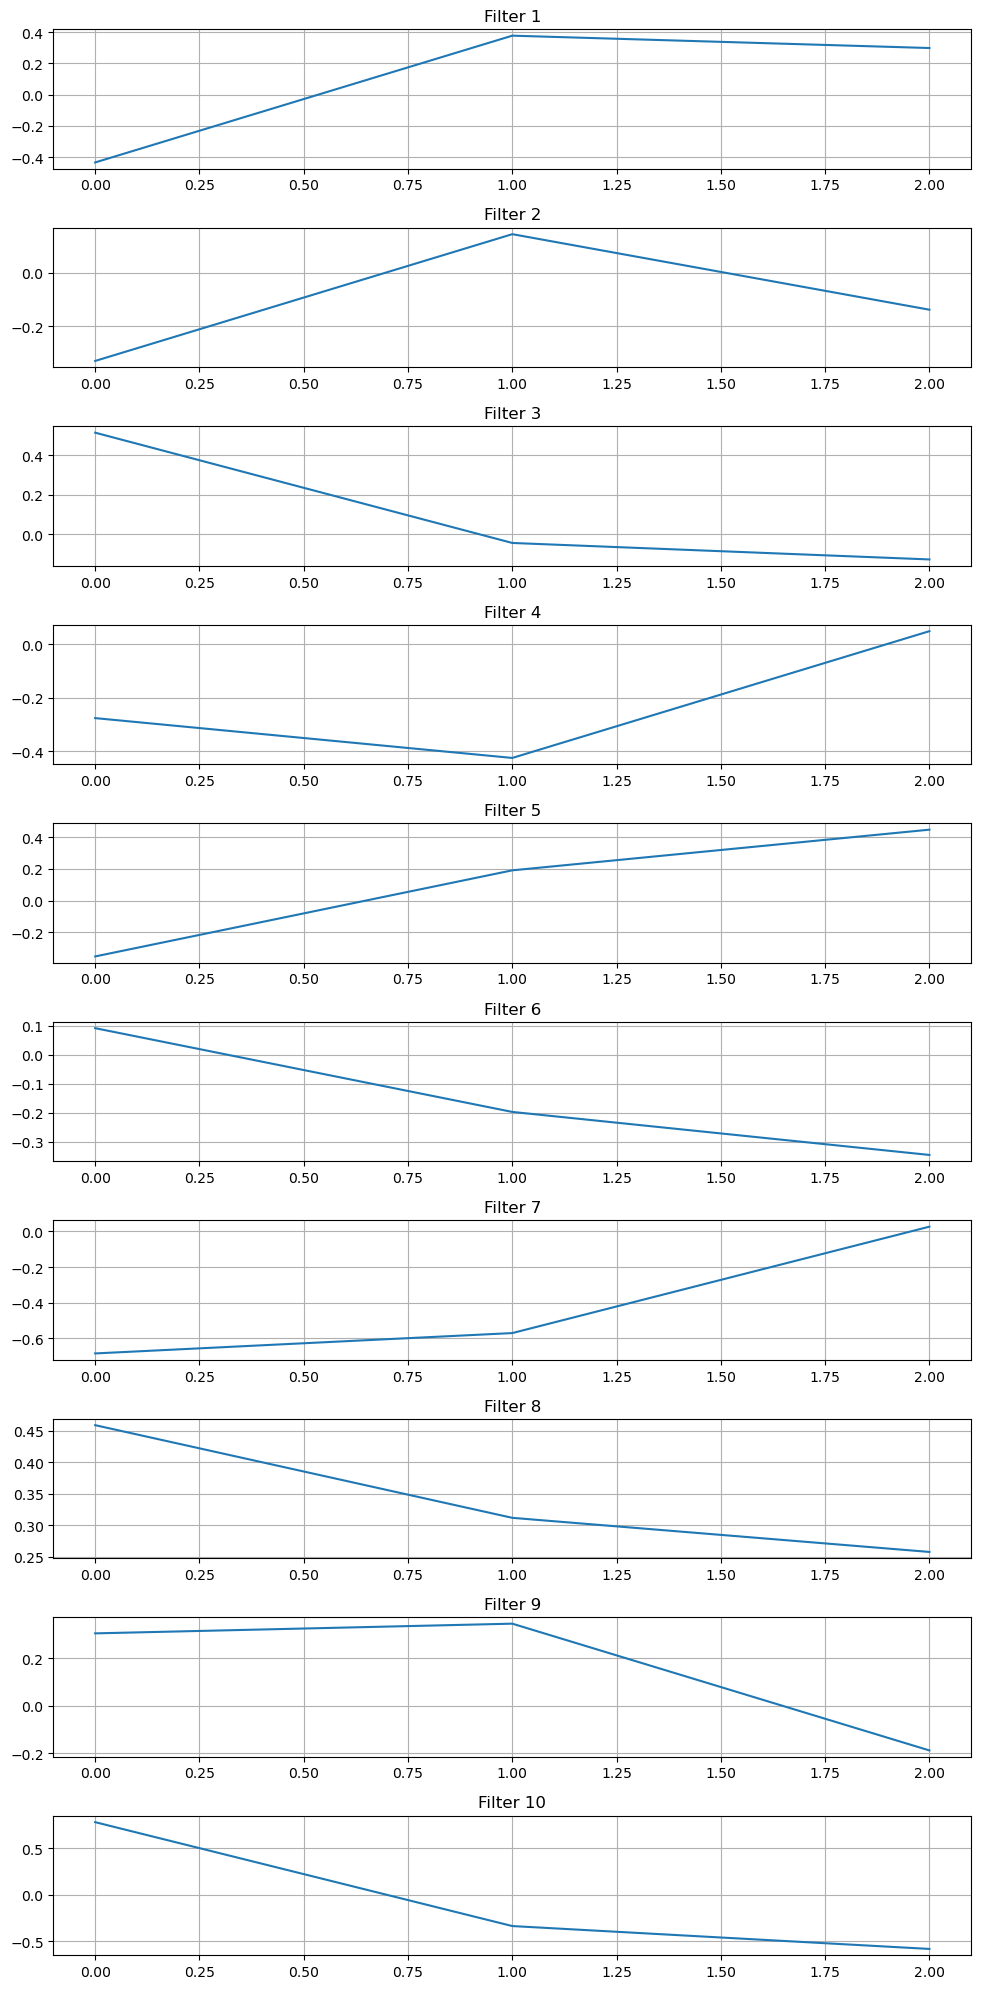

In [111]:

# Extract weights of the last Conv1D layer
last_conv_layer = model.layers[-3]  # This gets the Conv1D layer just before the last two Dense layers
weights_last_conv = last_conv_layer.get_weights()[0]  # [0] because it gets the kernel weights

num_filters = weights_last_conv.shape[-1]

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=num_filters, figsize=(10, num_filters * 2))

for i in range(num_filters):
    axes[i].plot(weights_last_conv[:, 0, i])
    axes[i].set_title(f"Filter {i + 1}")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


# Visualize

# Demonstrate Correct ordering

In [76]:
data=x_sequence[0]
print(data)
print(" ")
print(data.reshape(-1,10,3))
print(np.transpose(data))

[[0 1 0 0 0 0 0 0 1 1]
 [1 0 0 0 0 0 0 1 1 0]
 [0 1 0 0 0 0 0 1 1 0]]
 
[[[0 1 0]
  [0 0 0]
  [0 0 1]
  [1 1 0]
  [0 0 0]
  [0 0 1]
  [1 0 0]
  [1 0 0]
  [0 0 0]
  [1 1 0]]]
[[0 1 0]
 [1 0 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 1 1]
 [1 1 1]
 [1 0 0]]


# Just The Memory

In [36]:

from CaAttributes import CaNeighbourhoods, MemoryTypes, RuleTypes
import itertools
%load_ext autoreload
%autoreload 2
from CaMemory1D import CaMemory1D
from ca_funcs import make_glider, make_game_of_life
import tensorflow as tf
import numpy as np
import random
from train_ca import *
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
def collapse_sequences(sequences):
    collapsed_sequences=[]
    for sequence in sequences:
        for s in sequence:
            collapsed_sequences.append(s.sum())
    return np.array(collapsed_sequences).reshape(-1,sequence_length+1,1)
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs=None):
        if logs.get('val_accuracy') == 1:
            self.model.stop_training = True 
 
 
 
SEED =3
print("Starting...")
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.threading.set_inter_op_parallelism_threads(1)
 
gridsize=10
 
x_values = [seq for seq in itertools.product("01", repeat=gridsize)]

x_values = [[int(bit) for bit in seq] for seq in x_values]

MEMORY_CONSTANT=3
num_classes = 2  
sequence_length=MEMORY_CONSTANT*2
 
gol = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

gol.set_rule_number(38)

sequences= np.array(gol.generate_training_data_sequences(x_values,sequence_length=sequence_length))

print("Data generated") 

 
n = gridsize
 
np.random.shuffle(sequences)
y_sequence= []
x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
for x in x_sequence:
    y_sequence.append(gol.mostFrequentPastStateBinary(x))
y_sequence=np.array(y_sequence)

x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
 
Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), 2))
 
x_train = x_sequence
     
y_train_full= Y_val_onehot
split_ratio = 0.25
x_train_reshaped=[]
for data_point in x_train:
    x_train_reshaped.append(np.transpose(data_point))
x_train_reshaped=np.array(x_train_reshaped)  
 
split_point_x = int(len(x_train_reshaped) * split_ratio)
split_point_y = int(len(y_train_full) * split_ratio)
x_test = x_train_reshaped[:split_point_x]
y_test = y_train_full[:split_point_y]
x_train = x_train_reshaped[split_point_x:]
y_train = y_train_full[split_point_y:]
split_ratio = 0.5
split_point_x = int(len(x_test) * split_ratio)
split_point_y = int(len(y_test) * split_ratio)

# Split the data into validation and test sets
x_val = x_test[:split_point_x]
y_val = y_test[:split_point_x]
x_test = x_test[split_point_x:]
y_test = y_test[split_point_x:]

# Print the shapes of the resulting sets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

num_filters = 1
kernel_size = MEMORY_CONSTANT

    
memory_horizon=MEMORY_CONSTANT 
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(gridsize,memory_horizon   )))  

#model.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid',
 #                                kernel_initializer=keras.initializers.ones(), 
  #                                       bias_initializer=keras.initializers.he_normal(),trainable=True,use_bias=True,
   #                              activation="relu"
    #                            
     #                             ))

model.add(tf.keras.layers.SimpleRNN(units=1, return_sequences=True, activation='relu',
                               kernel_initializer=tf.keras.initializers.Ones()))

model.add(tf.keras.layers.Reshape((10,1)))
model.add(tf.keras.layers.Dense(units=2, activation="relu" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))
                           

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=loss, metrics=['accuracy'])
model.summary()
early_stopping_callback = CustomCallback()

x_train_reshaped=tf.convert_to_tensor( np.array(x_train), dtype=tf.float32)
model.fit(x_train_reshaped, y_train, validation_data=(x_val, y_val), epochs=5
        , batch_size=1,callbacks=[early_stopping_callback])
 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting...
Data generated
x_train shape: (768, 10, 3)
y_train shape: (768, 10, 2)
x_val shape: (128, 10, 3)
y_val shape: (128, 10, 2)
x_test shape: (128, 10, 3)
y_test shape: (128, 10, 2)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_23 (SimpleRNN)   (None, 10, 1)             5         
                                                                 
 reshape_20 (Reshape)        (None, 10, 1)             0         
                                                                 
 dense_16 (Dense)            (None, 10, 2)             4         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
768/768 [===========================

In [58]:
histories=[]
skipped=[]
failed=[]
i=0

# learning mutiple rules

In [37]:



SEED =3
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.threading.set_inter_op_parallelism_threads(1)
 

gridsize=10
MEMORY_CONSTANT=1
num_classes = 2
kernel_size=MEMORY_CONSTANT
sequence_length=MEMORY_CONSTANT*2

num_filters=1
gol = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

loss = lambda x, y: tf.keras.losses.categorical_crossentropy(tf.reshape(x, shape=(-1, num_classes)),tf.reshape(y, 
                                                                    shape=(-1, num_classes)),  from_logits=True)

 
SEED =3
print("Starting...")
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.threading.set_inter_op_parallelism_threads(1)
 
 
gridsize=10

x_values = [seq for seq in itertools.product("01", repeat=gridsize)]

x_values = [[int(bit) for bit in seq] for seq in x_values]
n = gridsize
 
np.random.shuffle(x_values)

y_sequence= []
x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
tries=0
 
while i< 256:
    print(i)
    
    gol = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)
    gol.set_rule_number(i)
    sequences= np.array(gol.generate_training_data_sequences(x_values,sequence_length=sequence_length))
    np.random.shuffle(sequences)
    x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
    y_sequence=sequences[:,MEMORY_CONSTANT*2]
    x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)

    x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)

    Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), 2))
    x_train = x_sequence

    y_train_full= Y_val_onehot
    split_ratio = 0.25
    x_train_reshaped=[]
    for data_point in x_train:
        x_train_reshaped.append(np.transpose(data_point))
    x_train_reshaped=np.array(x_train_reshaped)  

    split_point_x = int(len(x_train_reshaped) * split_ratio)
    split_point_y = int(len(y_train_full) * split_ratio)

   
    x_test = x_train_reshaped[:split_point_x]
    y_test = y_train_full[:split_point_y]
    x_train = x_train_reshaped[split_point_x:]
    y_train = y_train_full[split_point_y:]
    split_ratio = 0.5
    
    split_point_x = int(len(x_test) * split_ratio)
    split_point_y = int(len(y_test) * split_ratio)

 
    x_val = x_test[:split_point_x]
    y_val = y_test[:split_point_x]
    x_test = x_test[split_point_x:]
    y_test = y_test[split_point_x:]

    memory_horizon=MEMORY_CONSTANT# is equal to 1
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(gridsize,MEMORY_CONSTANT,1  )))  
    model.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid',
                                     kernel_initializer=keras.initializers.Ones(), 
                                             bias_initializer=tf.keras.initializers.he_normal(),trainable=True,use_bias=True,
                                     activation="relu"
                                      ))

    #model.add(tf.keras.layers.SimpleRNN(units=1, return_sequences=True, activation='relu',
     #                              kernel_initializer=tf.keras.initializers.Ones()))

    model.add(tf.keras.layers.Reshape((gridsize,1)))
    model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                    kernel_initializer=tf.keras.initializers.Ones(), 
                                    bias_initializer=tf.keras.initializers.Zeros()))
    model.add(Wraparound1D(padding=1))
    model.add(tf.keras.layers.Conv1D(10, 3, activation='relu', padding='valid',
                                     bias_initializer=tf.keras.initializers.Zeros(),
                                     trainable=True) )

    model.add(tf.keras.layers.Conv1D(8, 1, activation='relu', padding='same',
                                    bias_initializer=tf.keras.initializers.Zeros()))

    model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                    kernel_initializer=tf.keras.initializers.Ones(), 
                                    bias_initializer=tf.keras.initializers.Zeros()))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=loss, metrics=['accuracy'])
    #model.summary()
    early_stopping_callback = CustomCallback()

    x_train=x_train.reshape(-1,10,3,1)
    x_val=x_val.reshape(-1,10,3,1)
    x_test=x_test.reshape(-1,10,3,1)
    history=model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10
            , batch_size=1,callbacks=[early_stopping_callback], verbose=True) 
    eval=model.evaluate(x_test,y_test,verbose=False)

    if(eval[1] <0.97 or max(history.history["val_accuracy"])<0.97):
        print(eval[1])
        tries=tries+1
        i=i-1
        
   
    else:
        histories.append(history)
        print(i)
        tries=0
    if tries >5:
        tries=0
        failed.append(i)
        i=i+1
        print("skipped")
    i=i+1


Starting...
255
Epoch 1/10
768/768 [==============================] - 3s 3ms/step - loss: 0.3501 - accuracy: 0.9987 - val_loss: 0.3135 - val_accuracy: 1.0000
255


In [38]:
len(histories)

230

In [ ]:
indices_below_target = []

for idx, history in enumerate(histories):
    if all(accuracy <= 0.95 for accuracy in history.history['accuracy']):
        indices_below_target.append(idx)

print(len(indices_below_target))

In [57]:
file = open('hist1','w')
for item in histories:
	file.write(str(item.history["accuracy"])+", "+ str(item.history["val_accuracy"])+"\n")
file.close()

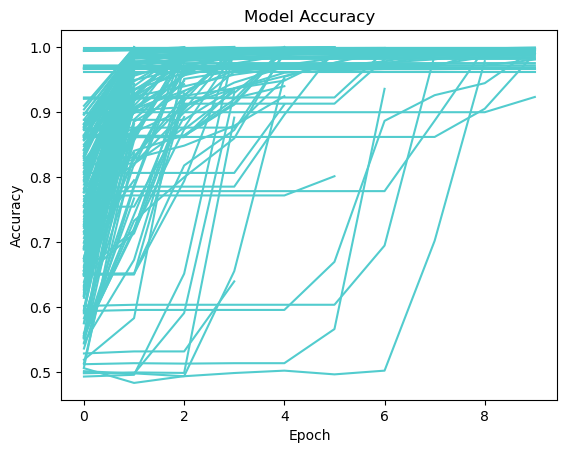

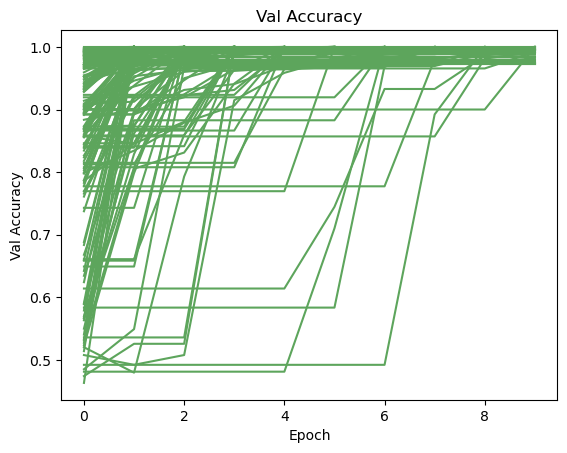

In [56]:
import matplotlib.pyplot as plt

# Plotting model accuracies
for history in histories:
    if max(history.history["accuracy"]):
        plt.plot(history.history["accuracy"], color="#52ccce")

plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig("Accuracy2 mem3")  # Save the figure first
plt.show()  # Then display it

# Plotting validation accuracies
for history in histories:
    if max(history.history["val_accuracy"]) >= 0.96:
        plt.plot(history.history["val_accuracy"], color="#5DA55c")

plt.title("Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.savefig("Val2 Accuracy mem3")  # Save the figure first
plt.show()  # Then display it


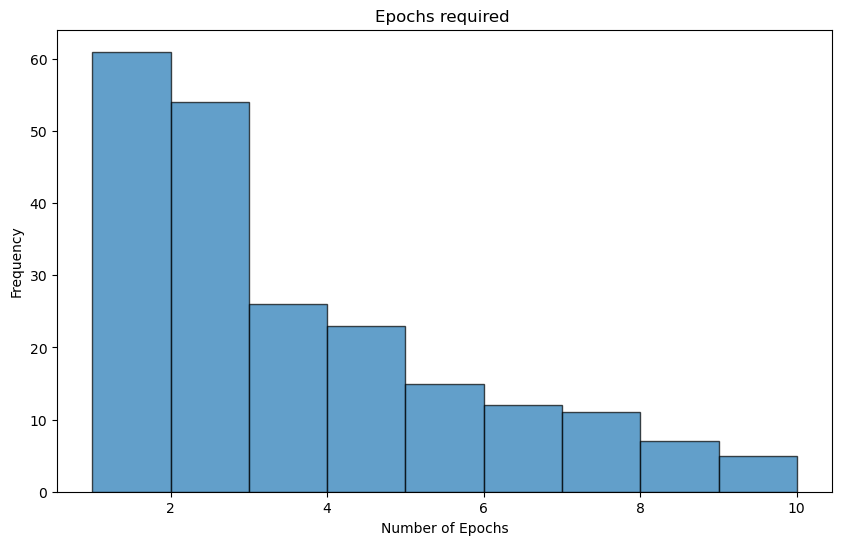

In [55]:
 plt.figure(figsize=(10, 6))
plt.hist(final_data, bins=range(1, 11), alpha=0.7, edgecolor='black')
plt.title('Epochs required ')
plt.xlabel('Number of Epochs')
plt.ylabel('Frequency')
plt.savefig("epochs_histogram.png")
plt.show()